# Assignment 3
# Part 1: Segmentation

## Problem 5
### Implement interactive seed-based segmentation using s/t graph cut algorithm.
#### A basic seed-interactive GUI "GraphCutsPresenter" is available (implemented in "asg1.py"). The starter code below uses it. Presenter allows to add seeds (left and right mouse clicks for object and background seeds) and displays these seeds over the image. However, instead of proper graph cut segmentation the provided code displays some fixed binary mask (just as an example of a mask). This "fixed" mask should be replaced by the output of an interactive image segmentation method based on minimum s/t graph cut respecting the hard constraints marked by the user-seeds. You can use an existing library for computing minimum s/t cuts on arbitrary graphs (e.g. install <a href="http://www.cs.uwaterloo.ca/~yboykov/Courses/cs484/python_lib/PyMaxflow-1.2.4.win-amd64-py2.7.exe">PyMaxflow 1.2.4</a>, see <a href="http://pmneila.github.io/PyMaxflow/maxflow.html">documentation</a>). You can use this library to build a weighted graph based on selected image and user-entered seeds.
#### As a first milestone, you should implement graph cut segmentation using only hard-constraints (from seeds) and "contrast-weights" $w_{pq}\propto \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ for neighborhood edges or "n-links", as suggested in Topic 9. Terminal "t-links" for seed-points should make sure that such graph nodes can not be severed from the corresponding terminals. You have to use "large-enough" finite cost t-links to enforce hard-constraints (user seeds) since "infinity" weight is not possible to implement. One can argue that $N\cdot \max \{w_{pq}\}$ (number of neighbors at each point times the largest n-link weight) is sufficient.
#### Once the first version above is implemented and tested, use seed pixels to compute color histograms $\Pr(I|1)$ and $\Pr(I|0)$ for two types of seeds. Computing histograms requires binning (quantization) of the color space that should be done via K-means over all image pixel colors (experiment with different bumber of bins K to see what works better in segmentation). Then, seed-pixels histograms $\Pr(I|1)$ and $\Pr(I|0)$ based on such bins should be used for unary potentials  $-\ln\Pr(I_p|1)$ and $-\ln\Pr(I_p|0)$ for all pixels $p$. Implement graph cut segmentation producing <font color=blue>seed-consistent</font> result $S$ minimizing the following objective (loss)
#### $$ E(S) = -\sum_p \ln\Pr(I_p|S_p) + \lambda \cdot \sum_{pq\in N} w_{pq} \cdot [S_p\neq S_q] . $$
#### Since seed-consistency is required, you should still enforce hard constraints on seeds.
#### NOTE 1: max-flow/min-cut libraries are typically more efficient when using integer edge weights in a relatively small range. You can use integer-weighted graph where edge weights are discretized/truncated values of your edge-weighting function.
#### NOTE 2: Test different values of "regularization parameter" $\lambda$ (scalar giving relative weight of the n-links vs t-links) as in the formula above.
#### NOTE 3: Play with parameter $\sigma$ for exponential n-link weighting function in $w_{pq}\propto \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ using intensity differences/contrast between two pixels. Test different values of  $\sigma$. Show 2-3 representative results (in different cells). Use markdown cell to discuss your observations, if any. If you can suggest some specific way of selecting some $\sigma$ adaptively to each image, provide a brief technical motivation for it.
#### NOTE 4: You can use either 4 or 8 connected grid.

In [1]:
%matplotlib notebook

# loading standard modules
import numpy as np
import matplotlib.pyplot as plt
import maxflow
import cv2
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from skimage import img_as_ubyte
from skimage.color import rgb2grey
from sklearn.cluster import KMeans
# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1_error_handling import Figure, GraphCutsPresenter

In [2]:
class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
    
    def __init__(self, img, sigma, lmbda):
        self.img = img
        self.sigma = sigma
        self.lmbda = lmbda
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)

        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]

    def run(self):
        self.fig.show()
        
    def compute_labels2(self, seed_mask):
        num_rows = self.num_rows
        num_cols = self.num_cols
        max_weight = np.iinfo(np.int16).max # humongous weight for seeds

        label_mask = np.full((num_rows, num_cols), self.none_value, dtype='uint8')
        
        if not np.any(seed_mask == self.bgr_value) or not np.any(seed_mask == self.obj_value):
            return label_mask
    
        graph = maxflow.Graph[int]()
        nodes = graph.add_grid_nodes((num_rows, num_cols))
        for i in range(num_rows):
            for j in range(num_cols):
                # add t-links
                mask = seed_mask[i, j]
                if mask == self.bgr_value:
                    graph.add_tedge(nodes[i, j], 0, max_weight)
                elif mask == self.obj_value:
                    graph.add_tedge(nodes[i, j], max_weight, 0)

                # add n-links
                nbrs = [(i,j+1), (i+1,j)]
                for nbr in nbrs:
                    if 0 <= nbr[0] < num_rows and 0 <= nbr[1] < num_cols:
                        diff = self.img[i, j] - self.img[nbr[0], nbr[1]]
                        weight = int(self.lmbda * np.exp(-1.0 * np.inner(diff, diff) / (2 * self.sigma**2)))
                        graph.add_edge(nodes[i, j], nodes[nbr[0], nbr[1]], weight, weight)
                        
        flow = graph.maxflow()
        segments = graph.get_grid_segments(nodes)
        label_mask[segments == True] = self.bgr_value
        label_mask[segments == False] = self.obj_value

        return label_mask
    
    def perform_kmeans(self, n_clusters=5):
        image = self.img.reshape((self.num_rows * self.num_cols, 3))
        kmeans = KMeans(n_clusters = n_clusters).fit(image)
        labels = kmeans.labels_.reshape((self.num_rows, self.num_cols))
        return labels
    
    def compute_histograms(self, seed_mask, kmeans_labels):
        bgr_labels = kmeans_labels[seed_mask == self.bgr_value]
        obj_labels = kmeans_labels[seed_mask == self.obj_value]

        bgr_labels_counter = Counter(bgr_labels)
        obj_labels_counter = Counter(obj_labels)
        
        return bgr_labels_counter, obj_labels_counter
    
    def compute_labels(self, seed_mask):
        num_rows = self.num_rows
        num_cols = self.num_cols
        max_weight = np.iinfo(np.int16).max # humongous weight for seeds
        K = 5 # num of clusters

        label_mask = np.full((num_rows, num_cols), self.none_value, dtype='uint8')

        # Seeds must be provided both for background and foreground
        if not np.any(seed_mask == self.bgr_value) or not np.any(seed_mask == self.obj_value):
            return label_mask

        labels = self.perform_kmeans(n_clusters=5)
        bgr_labels_counter, obj_labels_counter = self.compute_histograms(seed_mask, labels)
        total_bgr_points = np.sum(bgr_labels_counter.values())
        total_obj_points = np.sum(obj_labels_counter.values())

        graph = maxflow.Graph[float]()
        nodes = graph.add_grid_nodes((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # add t-links
                mask = seed_mask[i, j]
                if mask == self.bgr_value:
                    graph.add_tedge(nodes[i, j], 0, max_weight)
                elif mask == self.obj_value:
                    graph.add_tedge(nodes[i, j], max_weight, 0)
                else:
                    label_ij = labels[i, j]
                    prob_bgr = bgr_labels_counter[label_ij] / float(total_bgr_points)
                    prob_obj = obj_labels_counter[label_ij] / float(total_obj_points)
                    w1, w2 = 0, 0
                    if prob_obj == 0:
                        w1 = 0
                        w2 = max_weight
                    elif prob_bgr == 0:
                        w1 = max_weight
                        w2 = 0
                    else:
                        w1 = np.ceil(-1.0 * np.log(prob_bgr))
                        w2 = np.ceil(-1.0 * np.log(prob_obj))
                    graph.add_tedge(nodes[i, j], w1, w2)

                # add n-links
                nbrs = [(i,j+1), (i+1,j)]
                for nbr in nbrs:
                    if 0 <= nbr[0] < num_rows and 0 <= nbr[1] < num_cols:
                        diff = self.img[i, j] - self.img[nbr[0], nbr[1]]
                        weight = self.lmbda * np.ceil(np.exp(-1.0 * np.inner(diff, diff) / (2 * self.sigma**2)))
                        graph.add_edge(nodes[i, j], nodes[nbr[0], nbr[1]], weight, weight)

        flow = graph.maxflow()
        segments = graph.get_grid_segments(nodes)
        label_mask[segments == True] = self.bgr_value
        label_mask[segments == False] = self.obj_value

        return label_mask

### Notes about the basic graph cut interface:
1. To provide the regional hard constraints (seeds) for object and background segments use left and right mouse clicks (mouse dragging works somewhat too). Use mouse wheel to change the brush size.
2. The seed mask is built by the "GraphCutsPresenter". Each mouse release activates "on_mouse_up" function of the presenter, which asks the linked MyGraphCuts object to "compute_labels" for all pixels
based on the provided seed mask.
3. You should use "PyMaxflow" library (already imported into this notebook if you ran the second cell) to build a weighted graph and to compute a minimum s/t cut defining all pixel labels from the seeds as explain in topic 5.

<IPython.core.display.Javascript object>


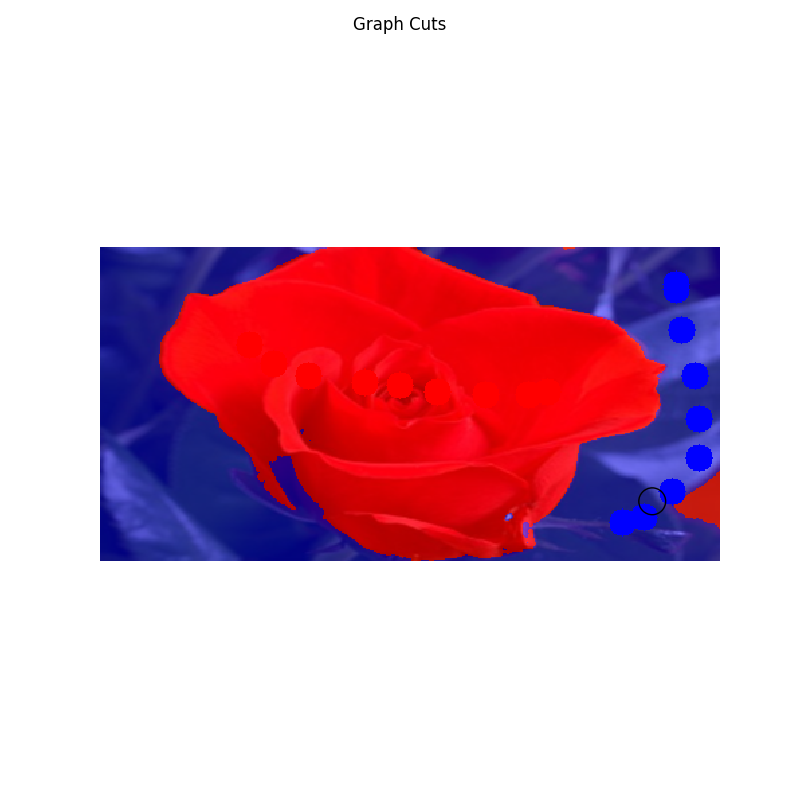

In [3]:
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600], 5.0, 0.01)
app.run()

### Add two more cells loading images (can use yours) where your implementation of MyGraphCuts works OK.

<IPython.core.display.Javascript object>


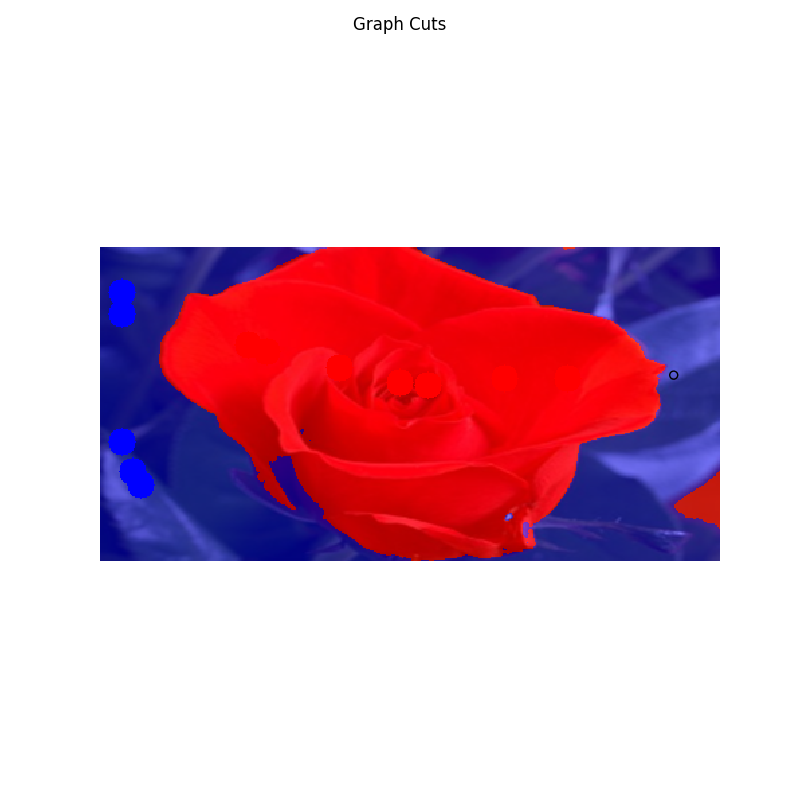

In [4]:
# value of lmbda increased
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600], 5.0, 1.0)
app.run()

<IPython.core.display.Javascript object>


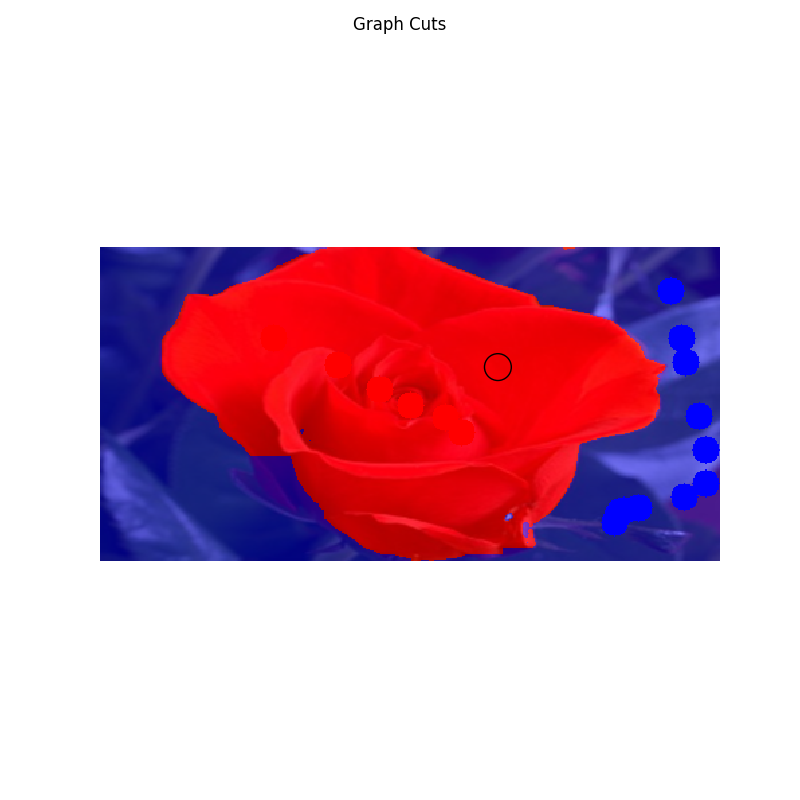

In [5]:
# value of lmbda changed
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600], 5.0, 20.0)
app.run()

<IPython.core.display.Javascript object>


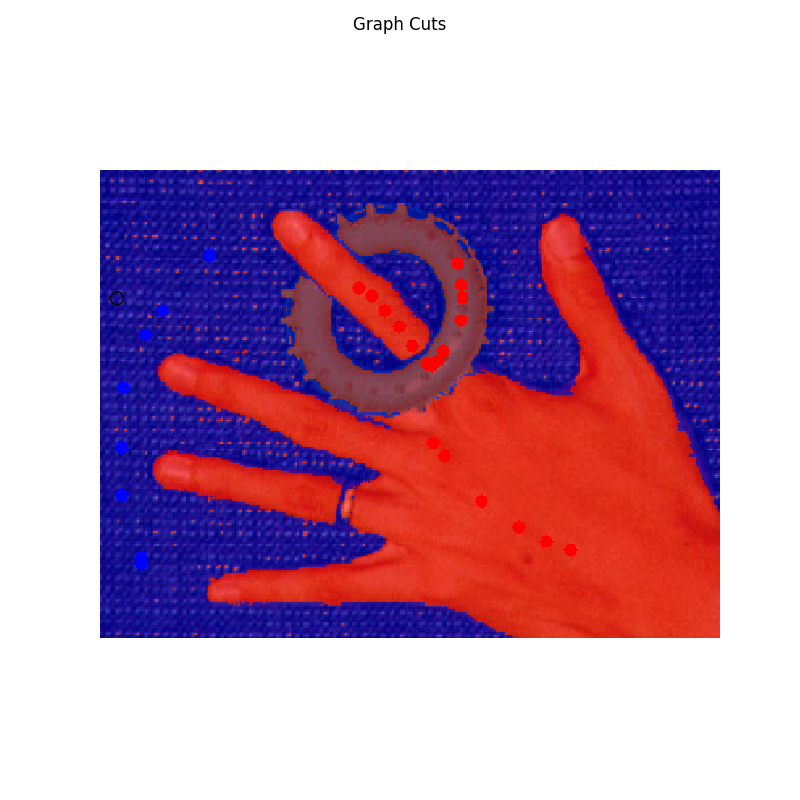

In [6]:
img = plt.imread('images/hand.bmp')
app = MyGraphCuts(img[10:300,:600], 5.0, 0.1)
app.run()

<IPython.core.display.Javascript object>


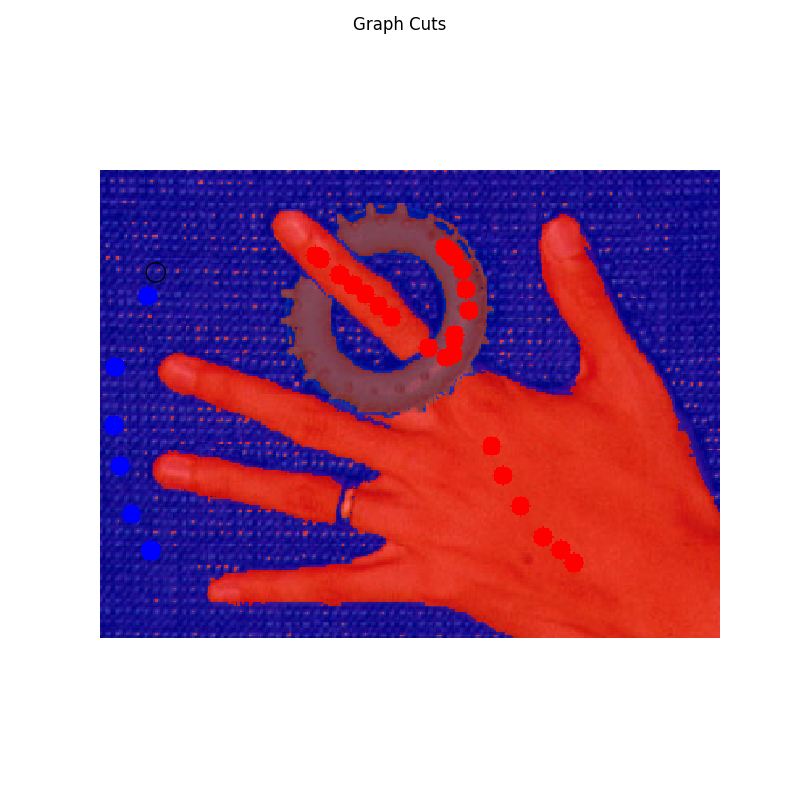

In [8]:
# value of sigma changed
img = plt.imread('images/hand.bmp')
app = MyGraphCuts(img[10:300,:600], 1.0, 0.1)
app.run()

<IPython.core.display.Javascript object>


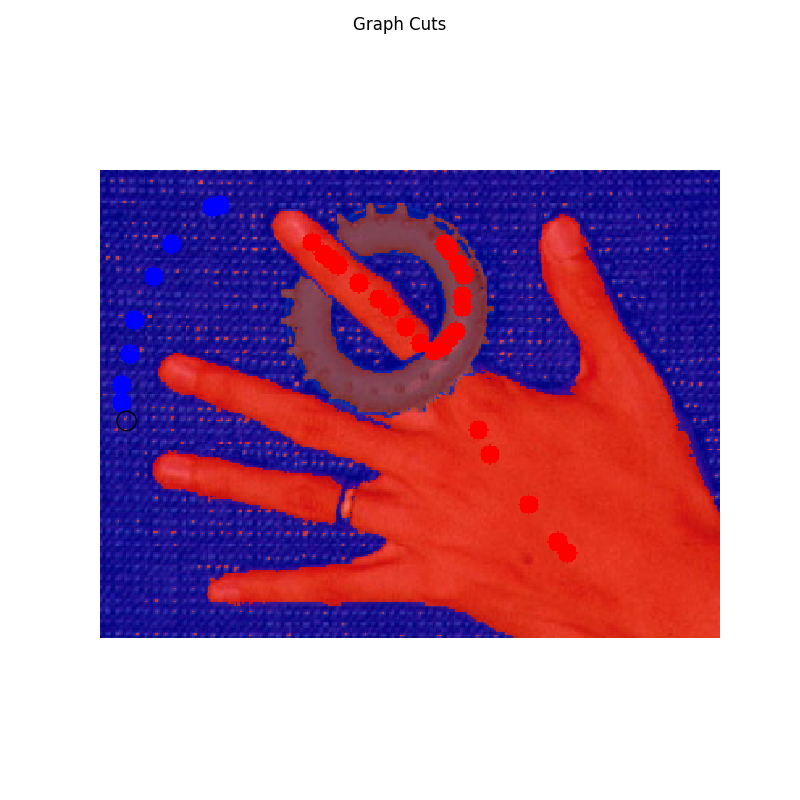

In [9]:
# value of sigma changed
img = plt.imread('images/hand.bmp')
app = MyGraphCuts(img[10:300,:600], 20.0, 0.1)
app.run()

<IPython.core.display.Javascript object>


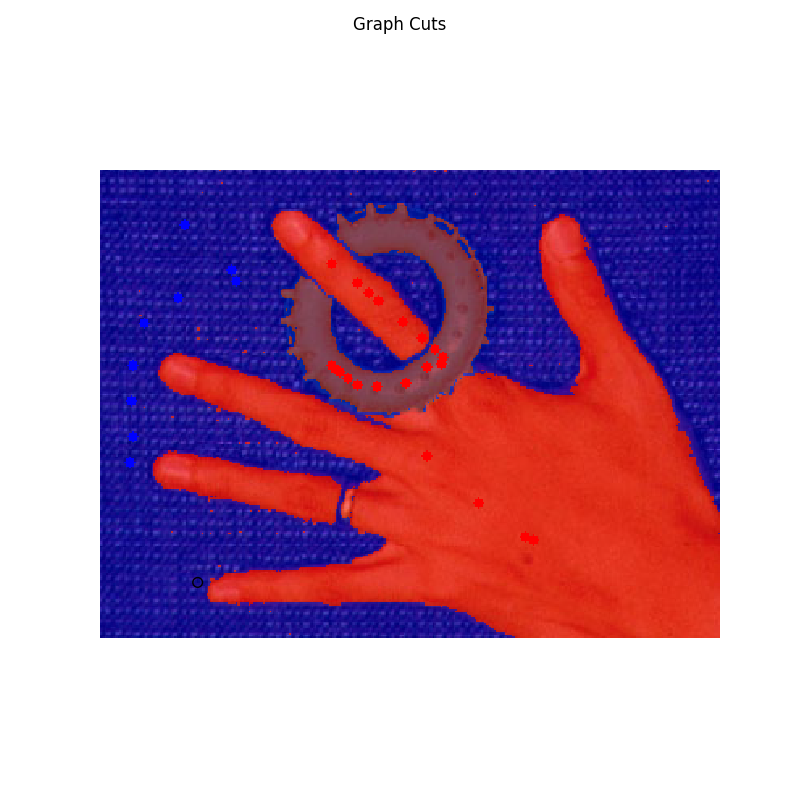

In [10]:
# value of lmbda increased significantly
img = plt.imread('images/hand.bmp')
app = MyGraphCuts(img[10:300,:600], 20.0, 100)
app.run()

### Observation: Higher value of lambda gives a better segmentation since it increases the weighted assigned to n-links. Which means edges are going to have a higher weightage and the segmentation will be smoother.

<IPython.core.display.Javascript object>


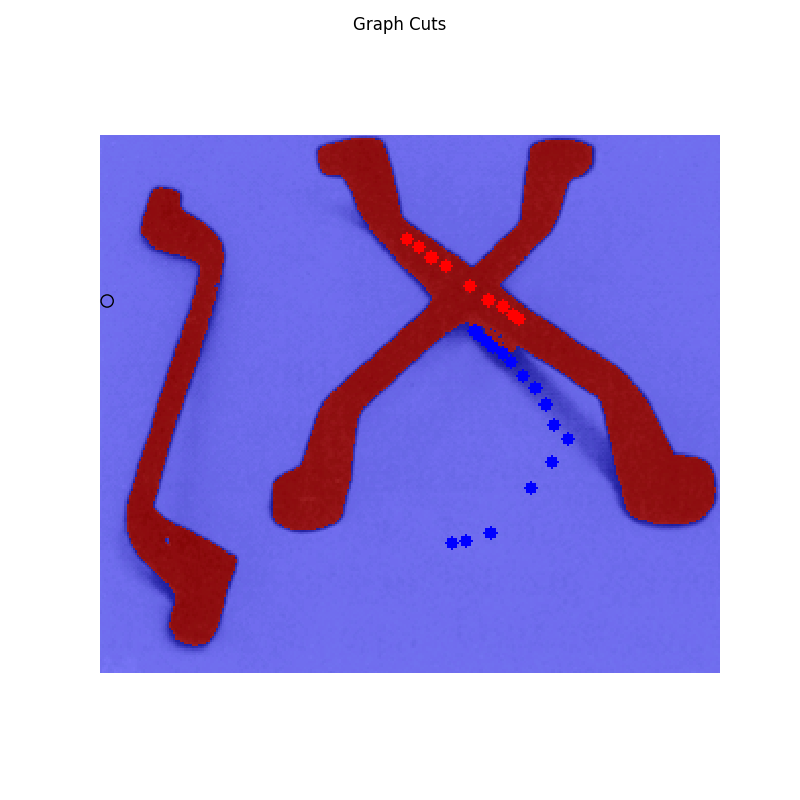

In [15]:
img = plt.imread('images/tools.bmp')
app = MyGraphCuts(img[10:300,:600], 5.0, 1)
app.run()